# Analysis of Archaelogical Soil Data and Experimental Lithic Data

In [1]:
# Load Packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Load Data
soil = pd.read_csv('ArchaeologicalSoilData.csv')
lithic = pd.read_csv('LithicExperimentalData.csv')
soil.head()
lithic.head()

,Id,Img Id,Da,Dp,FWidth,FLength,FThickness,ELength,EThickness,EWidth,...,W/L Ratio,W/T Ratio,T/W Ratio,CHull Surface Area,Sieve,Angularity,Ellipticity,Fiber Length,Fiber Width,Krumbein Rnd
0,,,mm,mm,mm,mm,mm,mm,mm,mm,...,,,,mm≤,mm,,,mm,mm,
1,104,10708,30.893,38.251,36.878,46.822,10.179,44.168,10.102,34.444,...,0.788,3.623,0.276,3211.655,23.529,19.392,4.372,49.768,22.823,0.214
2,19,5682,27.727,33.375,35.149,40.001,9.029,39.022,7.978,34.108,...,0.879,3.893,0.257,2547.278,22.089,20.688,4.891,37.445,5.128,0.214
3,14,4826,26.726,36.061,30.199,46.332,8.025,47.365,7.753,28.23,...,0.652,3.763,0.266,2571.497,19.112,21.25,6.11,52.384,17.379,0.219
4,1,2812,24.408,36.198,25.039,57.353,5.086,50.536,4.904,23.943,...,0.437,4.923,0.203,2001.165,15.063,18.233,10.304,51.467,17.096,0.251


In [3]:
# Print size of soil data
soil.shape

(73314, 48)

In [4]:
# Print size of lithic data
lithic.shape

(5300, 48)

# Part 1: K-Means Analysis with PCA

We expect that all the data falls into just one of two categories: either lithic or non-lithic. We want to verify that this is true a K-Means analysis.

In [5]:
# Combine data
# Drop first row from both data sets
soil = soil.tail(-1)
lithic = lithic.tail(-1)

# Add is_lithic feature to both data sets
soil['is_lithic'] = 0
lithic['is_lithic'] = 1

# To create a balanced data set, extract 5300 random rows from the soil data frame
soil_sample = soil.sample(n = 5299, random_state=333)

# Combine data frames
combined_data = [soil_sample, lithic]
combined_df = pd.concat(combined_data)

# Shuffle data frame
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [6]:
# Change data type
combined_df = combined_df.astype(str)

In [7]:
# Drop unwanted columns
combined_df = combined_df.drop(columns = ['Id', 'Img Id' , 'Filter0', 'Filter1', 'Filter2', 
                                          'Filter3', 'Filter4', 'Filter5', 'Filter6'])

In [8]:
# Scale the data
#import random
#random.seed = 3
mms = MinMaxScaler()
mms.fit(combined_df)
combined_transformed = mms.transform(combined_df)

In [9]:
# PCA to reduce dimensions
pca = PCA(3, random_state=3)
pca.fit(combined_transformed)
pca_scores = pca.transform(combined_transformed)

In [10]:
pca_scores

array([[ 0.87518694,  0.21848588,  0.03294356],
       [-0.13286982, -1.01652112,  0.0558589 ],
       [ 0.66629766, -0.02690236,  0.04025488],
       ...,
       [-1.12750973, -0.23403308,  0.44665989],
       [ 0.18596745, -0.63106763, -0.01464442],
       [ 0.27230238, -0.52380025, -0.0099559 ]])

In [11]:
# Get all columns
combined_df.columns

Index(['Da', 'Dp', 'FWidth', 'FLength', 'FThickness', 'ELength', 'EThickness',
       'EWidth', 'Volume', 'Area', 'Perimeter', 'CHull  Area',
       'CHull Perimeter', 'Sphericity', 'L/T Ratio', 'T/L Aspect Ratio',
       'Compactness', 'Roundness', 'Ellipse Ratio', 'Circularity', 'Solidity',
       'Concavity', 'Convexity', 'Extent', 'hash', 'Transparency', 'Curvature',
       'Surface Area', 'L/W Ratio', 'W/L Ratio', 'W/T Ratio', 'T/W Ratio',
       'CHull Surface Area', 'Sieve', 'Angularity', 'Ellipticity',
       'Fiber Length', 'Fiber Width', 'Krumbein Rnd', 'is_lithic'],
      dtype='object')

In [12]:
# Select top 10 commonly used parameters, according to provided document
params = ['Da','FWidth', 'FLength', 'FThickness', 'Sphericity', 'Circularity', 'W/L Ratio', 'L/W Ratio', 'Convexity',
         'Transparency']

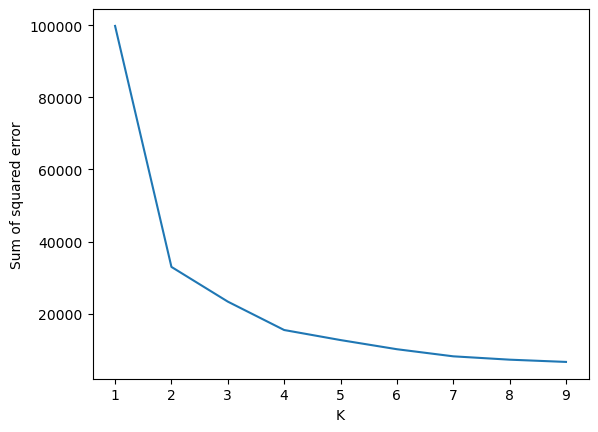

In [13]:
# Make elbow plot
sse = []
k_rng = range(1, 10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(combined_df[params])
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse);

Based on the elbow plot, 2 clusters is the most approproate for this data set.

In [14]:
# Perform KMeans fit
km = KMeans(n_clusters=2, init='k-means++', n_init = 1, max_iter=10, tol=1e-04, random_state=123)
km.fit(pca_scores)

KMeans(max_iter=10, n_clusters=2, n_init=1, random_state=123)

In [15]:
# Make new DataFrame and add clusters
new_df = pd.concat([combined_df.reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)
new_df.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
new_df['K-Means Cluster'] = km.labels_
new_df['Cluster'] = new_df['K-Means Cluster'].map({0: 'Cluster 1', 1: 'Cluster 2'})

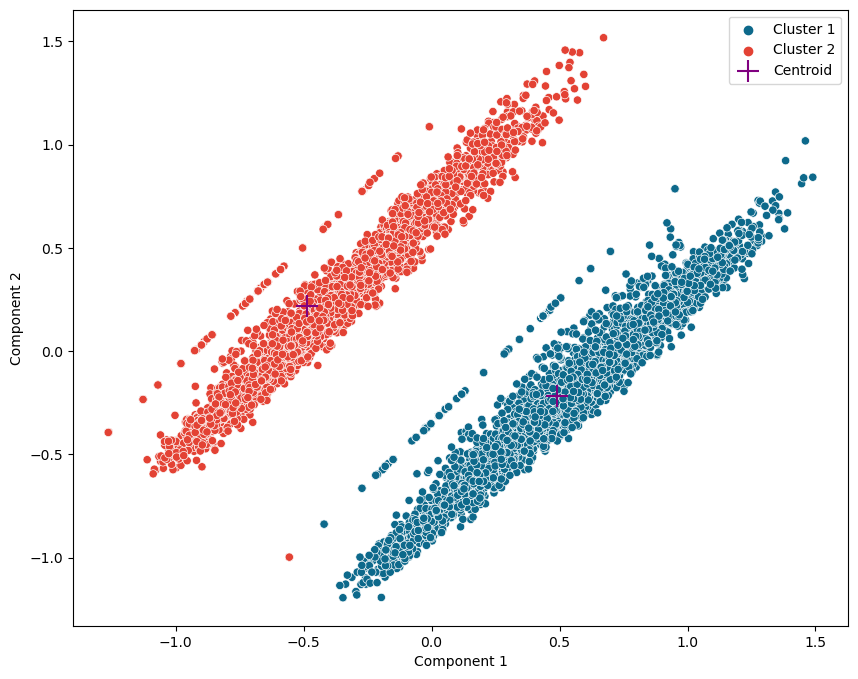

In [16]:
# Visualize K-Means
y = new_df['Component 2']
x = new_df['Component 1']
num_clusters = 2
colors = ['#0D698B', '#E34234']
plt.figure(figsize = (10,8))
ax = sns.scatterplot(data=new_df, x='Component 1', y='Component 2', hue='Cluster',
                palette = colors);
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color='purple', marker='+', label='Centroid',
           s = 250)
plt.legend();

Our K-Means analysis shows that there realy are two distinct clusters for the non-lithic and lithic data. However, there is one data points that appears to be misclassified. 

## Part 2: Testing all Models with Lazy Predict

Having finished the K-Means analysis, the next step is to determine which classifcation models are good candiates for classifying our data. To accomplsh this in a timely manner, we will make use of Lazy Predict to run all the classification models available in Sci-Kit Learn on our data to identify the top candidates. The metric we will be using to evaluate the performance of the models is the model accuracy.

In [17]:
# Get X and y data
X = combined_df.loc[:, combined_df.columns != 'is_lithic']
y = combined_df['is_lithic']

# Split X and y into training, test, and holdout sets


X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=132)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# Scale the data
mms = MinMaxScaler()
X_train_std = mms.fit_transform(X_train)
X_test_std = mms.transform(X_test)
X_hold_std = mms.transform(X_hold)

In [18]:
# Run Lazy Predict
import random
random.seed(123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=123)
models, predictions = clf.fit(X_train_std, X_test_std, y_train, y_test)
models

100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.88,0.88,0.88,0.88,0.15
RandomForestClassifier,0.88,0.88,0.88,0.88,1.48
BaggingClassifier,0.87,0.87,0.87,0.87,0.91
SVC,0.87,0.87,0.87,0.87,1.83
ExtraTreesClassifier,0.87,0.87,0.87,0.87,0.62
AdaBoostClassifier,0.87,0.86,0.86,0.87,1.04
NuSVC,0.86,0.86,0.86,0.86,3.01
KNeighborsClassifier,0.85,0.85,0.85,0.85,0.10
RidgeClassifier,0.85,0.85,NaN,0.85,0.09


The LGBM classifier appears to be the strongest canddiate for our classification task, with a baseline accuracy of approximately 89%. Therefore, the remainder of this analysis will be dedicated to fine-tuning the hyperparameters of an LGBM classifier to see if we can create a model with higher performance than the baseline accuracy. We will start by first choosing the best features to use to train this model by employing a feature selection algorithm.

## Part 3: Feature Selection with Sequential Feature Selection

When conducting our K-Means analysis, we selected the top 10 commonly used parameters as per the documentation that we were given. We want to use a feature selection algorithm to verify if these 10 parameters are the most important features. The feature selection algorithm that we will use is sequential feature selection (SFS). Once we have identified the 10 most significant features, we will use only these features when training our LGBM classifier.

In [19]:
# Performance of default LGBM on all features
lgbm = LGBMClassifier(objective=None, random_state=5)
lgbm.fit(X_train_std, y_train)
print('Training accuracy:', np.mean(lgbm.predict(X_train_std) == y_train)*100)
print('Test accuracy:', np.mean(lgbm.predict(X_test_std) == y_test)*100)

Training accuracy: 94.94865389952817
Test accuracy: 88.45726970033296


In [20]:
# 
import random
random.seed(123)
sfs1 = SFS(lgbm, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5)

sfs1 = sfs1.fit(X_train_std , y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   14.5s finished

[2023-02-06 02:51:54] Features: 1/10 -- score: 0.8155695930838597[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   15.0s finished

[2023-02-06 02:52:09] Features: 2/10 -- score: 0.8502628106348554[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   18.0s finished

[2023-02-06 02:52:27] Features: 3/10 -- score: 0.8603936047647602[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [21]:
# Most signficant features
combined_df.columns[1:][list(sfs1.k_feature_idx_)]

Index(['EThickness', 'Volume', 'L/T Ratio', 'T/L Aspect Ratio', 'Concavity',
       'Extent', 'hash', 'Curvature', 'Fiber Length', 'Fiber Width'],
      dtype='object')

In [22]:
# Perforance of default LGBM using best subset of features
X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

lgbm.fit(X_train_sele, y_train)
print('Training accuracy:', np.mean(lgbm.predict(X_train_sele) == y_train)*100)
print('Test accuracy:', np.mean(lgbm.predict(X_test_sele) == y_test)*100)

Training accuracy: 94.21315570358036
Test accuracy: 87.95782463928968


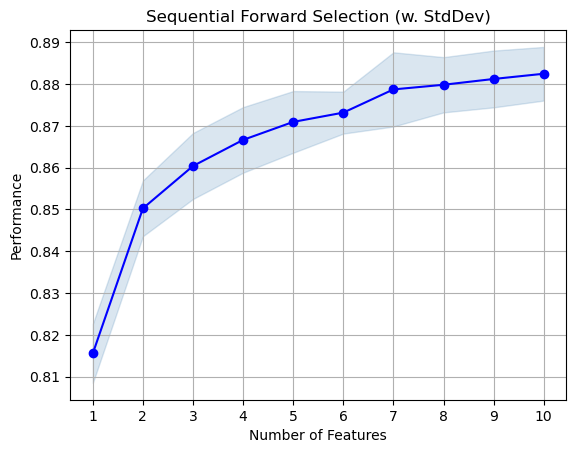

In [23]:
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict, kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

One key insight from this plot is that the graph has not fully plateued with 10 features, indicating that using more features might increase performance. Interestingly, the top 10 most significant features given by running sequential feature selection are a little different from the 10 most commonly used parameters. However, running the model on only this subset actually results in a decrease in performance, indicating that it is still better to use all features, although this is more computationally expensive.

# Part 4: Hyperparameter Tuning with GridSearchCV

We want to investigate if we can improve baseline performance of the model by tuning the hyperparamers. To find the ideal hyperparameters, we will use GridSearchCV.

In [24]:
import warnings
warnings.filterwarnings("ignore")

gridParams = {
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], 
    'boosting_type' : ['gbdt', 'dart'], 
    'objective' : ['binary'],
    'max_bin':[255, 510], 
    'random_state' : [5],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Data type conversion
X_train = X_train.astype(float)
y_train = pd.DataFrame(y_train)
y_train = y_train.astype(float)

# Create grid
grid = GridSearchCV(lgbm, gridParams, verbose=1, cv=4, n_jobs=-1)

# Run the grid
grid.fit(X_train, y_train.values.ravel())

# Print the best parameters found
print('best params')
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits
best params
{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'max_bin': 255, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'binary', 'random_state': 5, 'reg_alpha': 1, 'reg_lambda': 1.4, 'subsample': 0.7}
0.8670552215103091


# Part 5: Instantiate LGBM Model with Best Parameters

In [28]:
best_params = grid.best_params_
new_lgbm = LGBMClassifier(**best_params)
mdl = new_lgbm.fit(X_train, y_train)

# Part 6: Evaluate Model Performance on Test and Holdout Sets

Let's see how the modified model performs on the test and holdout sets. Not that values of 0 corresponds to samples that are non-lithic and values of 1 correspond to samples that are lithic.

In [29]:
# Data type conversion
X_test = X_test.astype(float)
y_test = y_test.astype(float)

pred_test = mdl.predict(X_test)
print("Test score: ", accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

Test score:  0.8795782463928968
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       916
         1.0       0.93      0.82      0.87       886

    accuracy                           0.88      1802
   macro avg       0.89      0.88      0.88      1802
weighted avg       0.88      0.88      0.88      1802



In [30]:
# Data type conversion
X_hold = X_hold.astype(float)
y_hold = y_hold.astype(float)

pred_hold = mdl.predict(X_hold)
print("Holdout score: ", accuracy_score(y_hold, pred_hold))
print(classification_report(y_hold, pred_hold))

Holdout score:  0.8654088050314466
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       796
         1.0       0.91      0.81      0.86       794

    accuracy                           0.87      1590
   macro avg       0.87      0.87      0.87      1590
weighted avg       0.87      0.87      0.87      1590

